In [1]:
import os
import re
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from snowballstemmer import RussianStemmer
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
tqdm.pandas()
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

## ПУНКТ 1

In [3]:
df = pd.read_csv("train.csv")
df["labels"] = df["labels"].apply(lambda x: np.array(list(map(int, x.strip().split())), dtype=np.int64))
print(df.head())
print(df.info())

   id                                               text  \
0   0  15 января\nДетская развлекательная программа\n...   
1   1  13 и 14 августа\nВыходные в Меге\nhttps://t.me...   
2   2  Йокнапатофа\nПостановка Театр им. Маяковского\...   
3   3  Впервые в Уфе танцевальная терапия в группе с ...   
4   4  🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...   

                                              labels  
0  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...  
1  [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...  
2  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...  
3  [1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29568 entries, 0 to 29567
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29568 non-null  int64 
 1   text    29568 non-null  object
 2   labels  29568 non-null  object
dtypes: int64(1), obj

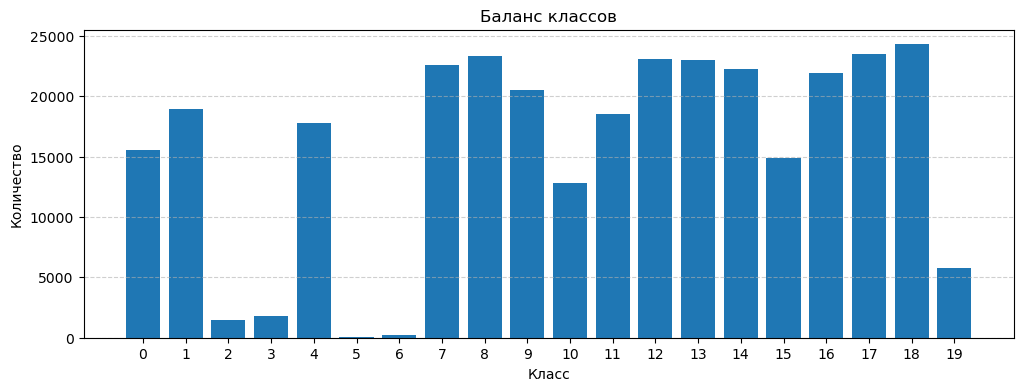

In [4]:
label_matrix = np.stack(df["labels"].values) 
class_counts = label_matrix.sum(axis=0)
plt.figure(figsize=(12, 4))
plt.bar(range(len(class_counts)), class_counts)
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.title("Баланс классов")
plt.xticks(range(20))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

In [5]:
selected_classes = random.sample(range(label_matrix.shape[1]), 5)

for class_idx in selected_classes:
    print(f"\nКласс {class_idx}:")
    class_examples = np.where(label_matrix[:, class_idx] == 1)[0]
    selected_examples = np.random.choice(class_examples, size=5, replace=False)
    
    for example_idx in selected_examples:
        print(f"Пример: {df.loc[example_idx]}\n")


Класс 9:
Пример: id                                                    17485
text      Похождения бравого солдата Швейка\n⏰\n7 феврал...
labels    [1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 17485, dtype: object

Пример: id                                                    23621
text      Органный уикенд со скидкой 50% по промокоду ТЕ...
labels    [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, ...
Name: 23621, dtype: object

Пример: id                                                     4091
text      ПРЕЗЕНТАЦИЯ ФОТОПРОЕКТА НАТАЛЬИ ИВАНОВОЙ «ЖИВА...
labels    [0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, ...
Name: 4091, dtype: object

Пример: id                                                     7924
text      Бесплатная пешеходная экскурсия "Новые воротни...
labels    [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, ...
Name: 7924, dtype: object

Пример: id                                                     1690
text      Сергей Безруков\nв роли Сергея Есенина, пригла...


Классы сильно не сбалансированы. Например, классы 5, 13, 2, 9 и 18 имеют разное количество примеров, при этом некоторые классы (например, класс 5) представлены значительно больше, чем другие (например, класс 18). Это может указывать на то, что модель, обученная на таких данных, будет хуже предсказывать редкие классы из-за их недостаточной представленности. Посмотрев на несколько примеров, можно увидеть, что большая часть текста это кириллица, однако также могут встречаться другие символы, в том числе смайлики.

## tf-idf + любая нейронная сеть

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
stop_words = set(stopwords.words('russian'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text, language='russian')
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

train_df['processed_text'] = train_df['text'].progress_apply(preprocess_text)
val_df['processed_text'] = val_df['text'].progress_apply(preprocess_text)

100%|██████████| 5914/5914 [00:01<00:00, 3490.51it/s]


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [11]:
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)

X_train = vectorizer.fit_transform(train_df['processed_text'])
X_val = vectorizer.transform(val_df['processed_text'])
y_train = np.stack(train_df['labels'].values)
y_val = np.stack(val_df['labels'].values)

In [12]:
class Dataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        self.has_labels = y is not None
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x_item = self.X[idx]
        if hasattr(x_item, 'toarray'):
            x_item = torch.FloatTensor(x_item.toarray()[0])
        else:
            x_item = torch.FloatTensor(x_item)
        
        if self.has_labels:
            y_item = torch.FloatTensor(self.y[idx])
            return x_item, y_item
        return x_item

In [13]:
train_dataset = Dataset(X_train, y_train)
val_dataset = Dataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [14]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.drop2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [15]:
def metric(y_true, y_pred):
    return f1_score(y_true, y_pred, average='samples')

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    best_f1 = 0.0
    patience = 10
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = (outputs > 0.5).float()
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        
        f1 = metric(all_labels, all_preds)
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(f1)
        scheduler.step(f1)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f} | LR: {current_lr:.2e}")
        
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    return history

In [17]:
model = NeuralNet(X_train.shape[1], y_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
history = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30 | Train Loss: 0.4026 | Val Loss: 0.2356 | Val F1: 0.9047 | LR: 1.00e-03
Epoch 2/30 | Train Loss: 0.2145 | Val Loss: 0.2071 | Val F1: 0.9123 | LR: 1.00e-03
Epoch 3/30 | Train Loss: 0.1719 | Val Loss: 0.2032 | Val F1: 0.9165 | LR: 1.00e-03
Epoch 4/30 | Train Loss: 0.1438 | Val Loss: 0.2060 | Val F1: 0.9179 | LR: 1.00e-03
Epoch 5/30 | Train Loss: 0.1245 | Val Loss: 0.2141 | Val F1: 0.9176 | LR: 1.00e-03
Epoch 6/30 | Train Loss: 0.1112 | Val Loss: 0.2217 | Val F1: 0.9170 | LR: 1.00e-03
Epoch 7/30 | Train Loss: 0.0993 | Val Loss: 0.2300 | Val F1: 0.9181 | LR: 1.00e-03
Epoch 8/30 | Train Loss: 0.0921 | Val Loss: 0.2352 | Val F1: 0.9172 | LR: 1.00e-03
Epoch 9/30 | Train Loss: 0.0855 | Val Loss: 0.2409 | Val F1: 0.9189 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.0786 | Val Loss: 0.2464 | Val F1: 0.9181 | LR: 1.00e-03
Epoch 11/30 | Train Loss: 0.0755 | Val Loss: 0.2565 | Val F1: 0.9182 | LR: 1.00e-03
Epoch 12/30 | Train Loss: 0.0709 | Val Loss: 0.2594 | Val F1: 0.9181 | LR: 1.00e-03
E


Best Validation F1 Score: 0.92


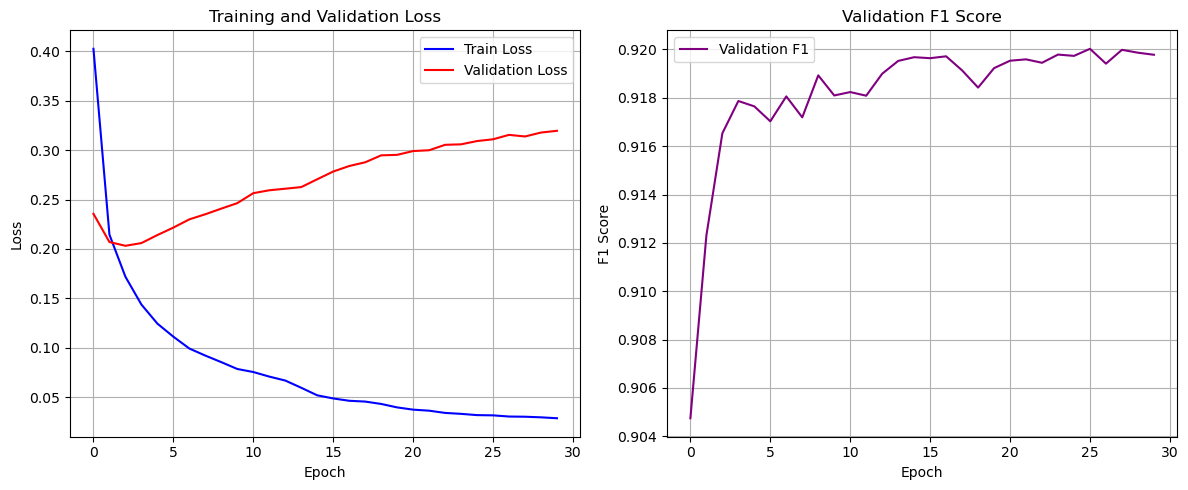

In [18]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    all_preds = []
    all_labels = []
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        all_preds.append(preds.cpu().numpy())  
        all_labels.append(labels.cpu().numpy())  
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    f1 = metric(all_labels, all_preds)
    print(f"\nBest Validation F1 Score: {round(f1, 4)}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Validation F1', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
test_df = pd.read_csv("test.csv")
test_df['processed_text'] = test_df['text'].progress_apply(preprocess_text)
X_test = vectorizer.transform(test_df['processed_text'])

100%|██████████| 7392/7392 [00:02<00:00, 3267.35it/s]


In [20]:
test_dataset = Dataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=128)

In [21]:
model = model.to(device)
model.eval()

test_preds = []

with torch.no_grad():  
    for inputs in test_loader:  
        inputs = inputs.to(device)   
        outputs = model(inputs)
        preds = (outputs > 0.5).int() 
        test_preds.append(preds.cpu().numpy())  
test_preds = np.concatenate(test_preds, axis=0)

print("Тестовые предсказания:", test_preds[:10])

Тестовые предсказания: [[0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1]
 [0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0]
 [1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0]
 [1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1]
 [1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0]
 [0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0]
 [0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0]
 [0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0]
 [0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0]]


In [22]:
test_id = test_df['id']
test_id = test_df['id']
labels = [' '.join(map(str, pred)) for pred in test_preds]

results = pd.DataFrame({
    'id': test_id,
    'labels': labels
})

print(results.head())

      id                                   labels
0  29568  0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
1  29569  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3  29571  1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0
4  29572  1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1


Модель выдаёт хорошие результаты на вале около 0.92 на тесте результат около 0.83

## w2v + любая нейронная сеть

In [25]:
def tokenize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text, language='russian')
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return tokens
train_df['tokens'] = train_df['text'].progress_apply(tokenize_text)
val_df['tokens'] = val_df['text'].progress_apply(tokenize_text)

100%|██████████| 5914/5914 [00:01<00:00, 3385.72it/s]


In [26]:
w2v_model = Word2Vec(
    sentences=train_df['tokens'],
    vector_size=100,    
    window=5,           
    min_count=3,        
    workers=4           
)

In [27]:
def text_to_vector(tokens, model):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [28]:
X_train_w2v = np.array([text_to_vector(tokens, w2v_model) for tokens in train_df['tokens']])
X_val_w2v = np.array([text_to_vector(tokens, w2v_model) for tokens in val_df['tokens']])
train_dataset_w2v = Dataset(X_train_w2v, y_train)
val_dataset_w2v = Dataset(X_val_w2v, y_val)
train_loader_w2v = DataLoader(train_dataset_w2v, batch_size=128, shuffle=True)
val_loader_w2v = DataLoader(val_dataset_w2v, batch_size=128)

In [29]:
class Word2VecNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Word2VecNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.drop2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [30]:
model_w2v = Word2VecNet(X_train_w2v.shape[1], y_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_w2v.parameters(), lr=1e-3)
history_w2v = train_model(model_w2v, train_loader_w2v, val_loader_w2v, criterion, optimizer, epochs=30)

Epoch 1/30 | Train Loss: 0.4621 | Val Loss: 0.3142 | Val F1: 0.8730 | LR: 1.00e-03
Epoch 2/30 | Train Loss: 0.3191 | Val Loss: 0.2884 | Val F1: 0.8774 | LR: 1.00e-03
Epoch 3/30 | Train Loss: 0.3047 | Val Loss: 0.2811 | Val F1: 0.8798 | LR: 1.00e-03
Epoch 4/30 | Train Loss: 0.2991 | Val Loss: 0.2774 | Val F1: 0.8819 | LR: 1.00e-03
Epoch 5/30 | Train Loss: 0.2950 | Val Loss: 0.2744 | Val F1: 0.8838 | LR: 1.00e-03
Epoch 6/30 | Train Loss: 0.2920 | Val Loss: 0.2728 | Val F1: 0.8831 | LR: 1.00e-03
Epoch 7/30 | Train Loss: 0.2889 | Val Loss: 0.2693 | Val F1: 0.8850 | LR: 1.00e-03
Epoch 8/30 | Train Loss: 0.2867 | Val Loss: 0.2684 | Val F1: 0.8857 | LR: 1.00e-03
Epoch 9/30 | Train Loss: 0.2842 | Val Loss: 0.2656 | Val F1: 0.8877 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.2832 | Val Loss: 0.2644 | Val F1: 0.8873 | LR: 1.00e-03
Epoch 11/30 | Train Loss: 0.2826 | Val Loss: 0.2645 | Val F1: 0.8870 | LR: 1.00e-03
Epoch 12/30 | Train Loss: 0.2809 | Val Loss: 0.2647 | Val F1: 0.8864 | LR: 1.00e-03
E

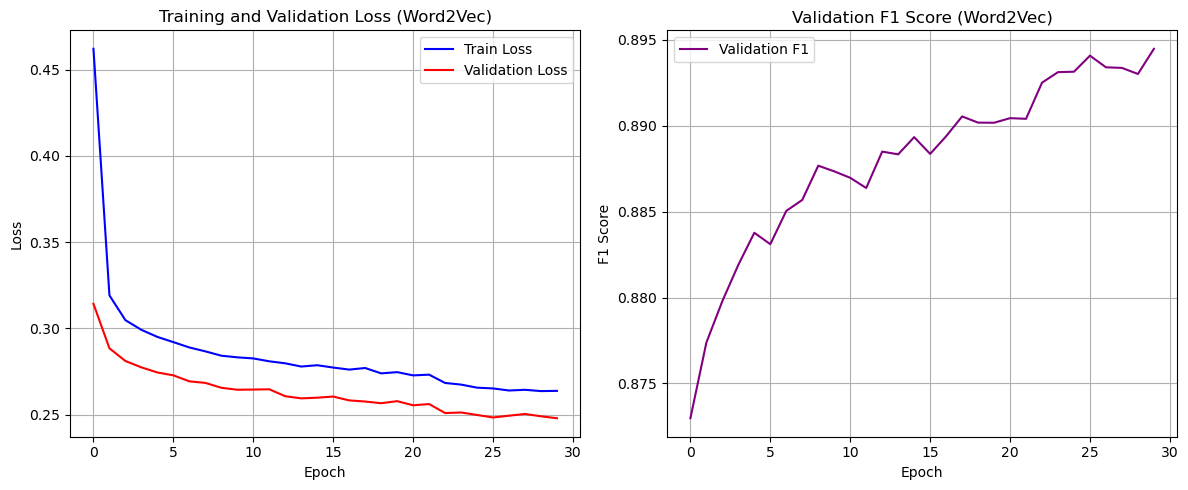

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_w2v['train_loss'], label='Train Loss', color='blue')
plt.plot(history_w2v['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Word2Vec)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history_w2v['val_f1'], label='Validation F1', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score (Word2Vec)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Модель выдаёт хорошие результаты на вале около 0.9, однако на тесте результат около 0.76

## встроенный эмбеддинг в нейросетевое решение на свёрточных сетях

In [34]:
def preprocess_text_for_cnn(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [35]:
class TextTokenizer:
    def __init__(self, max_words=20000):
        self.max_words = max_words
        self.word_index = {}
        self.index_word = {}
        
    def fit_on_texts(self, texts):
        word_counts = {}
        for text in texts:
            for word in text.split():
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        sorted_words = sorted_words[:self.max_words-1]
        
        self.word_index = {word: i+1 for i, (word, count) in enumerate(sorted_words)}
        self.word_index['<OOV>'] = 0  
        self.index_word = {i: word for word, i in self.word_index.items()}
    
    def texts_to_sequences(self, texts, max_len=100):
        sequences = []
        for text in texts:
            seq = []
            words = text.split()[:max_len]  
            for word in words:
                seq.append(self.word_index.get(word, 0))  # 0 для OOV
            sequences.append(seq)
        return sequences

In [36]:
class PaddedSequenceDataset(Dataset):
    def __init__(self, sequences, y=None, max_len=100):
        self.sequences = sequences
        self.y = y
        self.has_labels = y is not None
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        if len(seq) < self.max_len:
            seq = seq + [0] * (self.max_len - len(seq))
        else:
            seq = seq[:self.max_len]
        
        x_item = torch.LongTensor(seq)
        
        if self.has_labels:
            y_item = torch.FloatTensor(self.y[idx])
            return x_item, y_item
        return x_item

In [37]:
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, max_len=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.conv_blocks = nn.Sequential(
            nn.Conv1d(embedding_dim, 64, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.7),  
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.7)  
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * (max_len // 2), 64),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.embedding(x)  
        x = x.permute(0, 2, 1)  
        
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)  
        
        return torch.sigmoid(self.classifier(x))

In [38]:
train_df['text_for_cnn'] = train_df['text'].progress_apply(preprocess_text_for_cnn)
val_df['text_for_cnn'] = val_df['text'].progress_apply(preprocess_text_for_cnn)
test_df['text_for_cnn'] = test_df['text'].progress_apply(preprocess_text_for_cnn)

y_train = np.stack(train_df['labels'].values)
y_val = np.stack(val_df['labels'].values)

tokenizer = TextTokenizer(max_words=20000)
tokenizer.fit_on_texts(train_df['text_for_cnn'])  

X_train_seq = tokenizer.texts_to_sequences(train_df['text_for_cnn'])
X_val_seq = tokenizer.texts_to_sequences(val_df['text_for_cnn'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text_for_cnn'])

text_lengths = [len(seq) for seq in X_train_seq]
max_seq_len = int(np.percentile(text_lengths, 95))

100%|██████████| 7392/7392 [00:00<00:00, 18048.85it/s]


In [39]:
train_seq_dataset = PaddedSequenceDataset(X_train_seq, y_train, max_len=max_seq_len)
val_seq_dataset = PaddedSequenceDataset(X_val_seq, y_val, max_len=max_seq_len)
test_seq_dataset = PaddedSequenceDataset(X_test_seq, max_len=max_seq_len)

train_seq_loader = DataLoader(train_seq_dataset, batch_size=128, shuffle=True)
val_seq_loader = DataLoader(val_seq_dataset, batch_size=128)
test_seq_loader = DataLoader(test_seq_dataset, batch_size=128)

In [40]:
vocab_size = len(tokenizer.word_index)
embedding_dim = 128
num_classes = y_train.shape[1]

model = CNNTextClassifier(vocab_size, embedding_dim, num_classes, max_seq_len).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCELoss()

history = train_model(
    model, 
    train_seq_loader, 
    val_seq_loader, 
    criterion, 
    optimizer, 
    epochs=30
)

Epoch 1/30 | Train Loss: 0.4299 | Val Loss: 0.4448 | Val F1: 0.8001 | LR: 1.00e-03
Epoch 2/30 | Train Loss: 0.3569 | Val Loss: 0.4043 | Val F1: 0.8189 | LR: 1.00e-03
Epoch 3/30 | Train Loss: 0.3444 | Val Loss: 0.3969 | Val F1: 0.8200 | LR: 1.00e-03
Epoch 4/30 | Train Loss: 0.3360 | Val Loss: 0.3706 | Val F1: 0.8350 | LR: 1.00e-03
Epoch 5/30 | Train Loss: 0.3255 | Val Loss: 0.3376 | Val F1: 0.8488 | LR: 1.00e-03
Epoch 6/30 | Train Loss: 0.3171 | Val Loss: 0.3338 | Val F1: 0.8516 | LR: 1.00e-03
Epoch 7/30 | Train Loss: 0.3099 | Val Loss: 0.3209 | Val F1: 0.8532 | LR: 1.00e-03
Epoch 8/30 | Train Loss: 0.3042 | Val Loss: 0.3114 | Val F1: 0.8606 | LR: 1.00e-03
Epoch 9/30 | Train Loss: 0.2985 | Val Loss: 0.3029 | Val F1: 0.8658 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.2950 | Val Loss: 0.2971 | Val F1: 0.8655 | LR: 1.00e-03
Epoch 11/30 | Train Loss: 0.2922 | Val Loss: 0.2946 | Val F1: 0.8698 | LR: 1.00e-03
Epoch 12/30 | Train Loss: 0.2887 | Val Loss: 0.2903 | Val F1: 0.8694 | LR: 1.00e-03
E

In [41]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    all_preds = []
    all_labels = []
    for inputs, labels in val_seq_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    f1 = metric(all_labels, all_preds)
    print(f"\nBest CNN Validation F1 Score: {round(f1, 4)}")


Best CNN Validation F1 Score: 0.8812


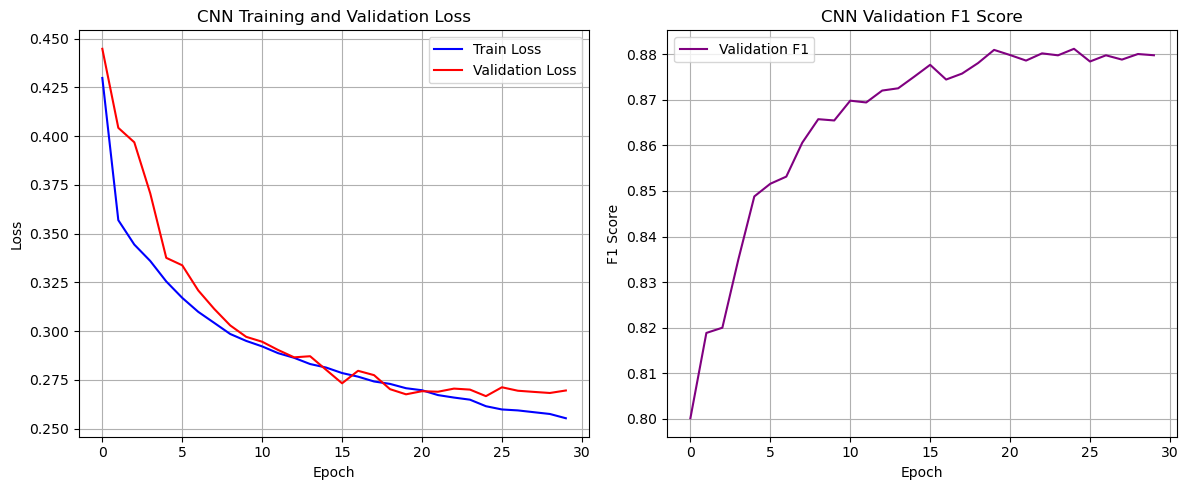

In [42]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Validation F1', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('CNN Validation F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Модель выдаёт результаты на вале около 0.89, однако на тесте результат ещё хуже чем у прошлой модели около 0.73

## встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях

In [45]:
y_train = np.stack(train_df['labels'].values)
y_val = np.stack(val_df['labels'].values)
def preprocess_for_embeddings(text):
    text = text.lower()
    text = re.sub(r'[^\w\s.,!?]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [46]:
print("Преобразование текстов для LSTM...")
train_df['processed_text'] = train_df['text'].progress_apply(preprocess_for_embeddings)
val_df['processed_text'] = val_df['text'].progress_apply(preprocess_for_embeddings)
test_df['processed_text'] = test_df['text'].progress_apply(preprocess_for_embeddings)

Преобразование текстов для LSTM...


100%|██████████| 7392/7392 [00:00<00:00, 24707.85it/s]


In [47]:
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(
    num_words=MAX_WORDS,
    filters='',
    lower=False,
    oov_token='<UNK>'
)
tokenizer.fit_on_texts(train_df['processed_text'])

In [48]:
X_train_seq = tokenizer.texts_to_sequences(train_df['processed_text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['processed_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['processed_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [49]:
class SequenceDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        self.has_labels = y is not None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x_item = torch.LongTensor(self.X[idx])
        if self.has_labels:
            y_item = torch.FloatTensor(self.y[idx])
            return x_item, y_item
        return x_item

In [50]:
train_seq_dataset = SequenceDataset(X_train_pad, y_train)
val_seq_dataset = SequenceDataset(X_val_pad, y_val)
test_seq_dataset = SequenceDataset(X_test_pad)

train_seq_loader = DataLoader(train_seq_dataset, batch_size=128, shuffle=True)
val_seq_loader = DataLoader(val_seq_dataset, batch_size=128)
test_seq_loader = DataLoader(test_seq_dataset, batch_size=128)

In [51]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTMNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Берем последний hidden state
        x = self.dropout(lstm_out)
        x = torch.sigmoid(self.fc(x))
        return x

In [52]:
VOCAB_SIZE = min(MAX_WORDS, len(tokenizer.word_index) + 1)
EMBEDDING_DIM = 128
HIDDEN_DIM = 192
NUM_CLASSES = y_train.shape[1]

lstm_model = LSTMNet(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
optimizer = optim.AdamW(lstm_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCELoss()

print("\nОбучение LSTM модели...")
lstm_history = train_model(lstm_model, train_seq_loader, val_seq_loader, criterion, optimizer, epochs=30)


Обучение LSTM модели...
Epoch 1/30 | Train Loss: 0.3903 | Val Loss: 0.3267 | Val F1: 0.8458 | LR: 1.00e-03
Epoch 2/30 | Train Loss: 0.3296 | Val Loss: 0.3190 | Val F1: 0.8524 | LR: 1.00e-03
Epoch 3/30 | Train Loss: 0.3152 | Val Loss: 0.2966 | Val F1: 0.8560 | LR: 1.00e-03
Epoch 4/30 | Train Loss: 0.2958 | Val Loss: 0.2809 | Val F1: 0.8760 | LR: 1.00e-03
Epoch 5/30 | Train Loss: 0.2813 | Val Loss: 0.2703 | Val F1: 0.8812 | LR: 1.00e-03
Epoch 6/30 | Train Loss: 0.2684 | Val Loss: 0.2646 | Val F1: 0.8824 | LR: 1.00e-03
Epoch 7/30 | Train Loss: 0.2587 | Val Loss: 0.2580 | Val F1: 0.8877 | LR: 1.00e-03
Epoch 8/30 | Train Loss: 0.2500 | Val Loss: 0.2522 | Val F1: 0.8917 | LR: 1.00e-03
Epoch 9/30 | Train Loss: 0.2407 | Val Loss: 0.2471 | Val F1: 0.8939 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.2320 | Val Loss: 0.2435 | Val F1: 0.8969 | LR: 1.00e-03
Epoch 11/30 | Train Loss: 0.2244 | Val Loss: 0.2390 | Val F1: 0.8979 | LR: 1.00e-03
Epoch 12/30 | Train Loss: 0.2161 | Val Loss: 0.2351 | Val F1

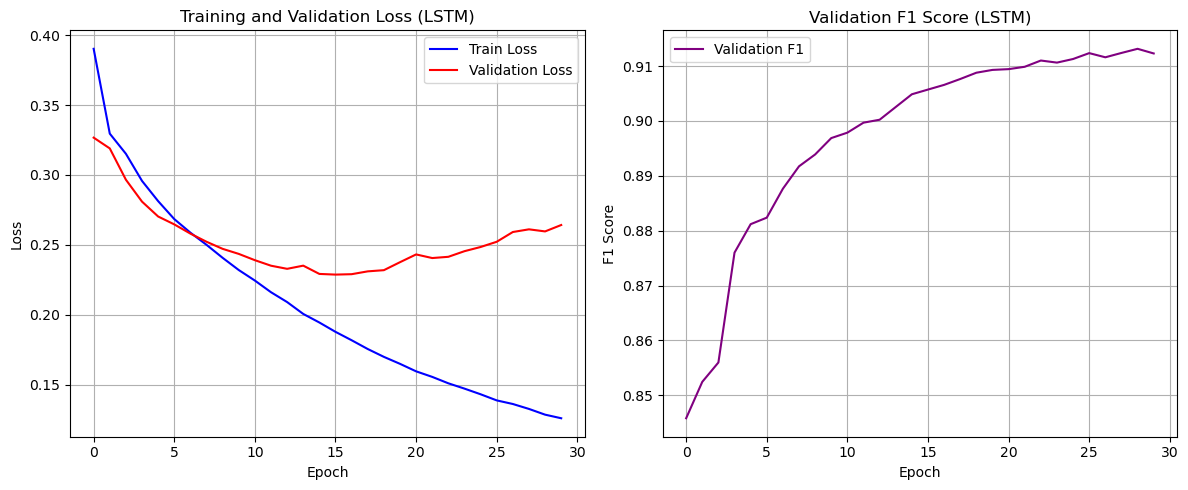

In [53]:
lstm_model.load_state_dict(torch.load('best_model.pth'))
lstm_model.eval()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history['train_loss'], label='Train Loss', color='blue')
plt.plot(lstm_history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (LSTM)')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(lstm_history['val_f1'], label='Validation F1', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score (LSTM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Модель выдаёт хорошие результаты на вале около 0.915, однако на тесте результат около 0.78

## эмбеддер + решение на bert-like моделях (лучшая модель)

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from snowballstemmer import RussianStemmer
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
tqdm.pandas()
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW 

In [ ]:
df = pd.read_csv("train.csv")
df["labels"] = df["labels"].apply(lambda x: np.array(list(map(int, x.strip().split())), dtype=np.int64))
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
def metric(y_true, y_pred):
    return f1_score(y_true, y_pred, average='samples')
test_df = pd.read_csv("test.csv")

In [ ]:
BERT_MODEL_NAME = 'bert-base-multilingual-cased'
MAX_LEN = 128
BATCH_SIZE = 16 
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
class BertDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        if self.has_labels:
            item['labels'] = torch.FloatTensor(self.labels[idx])
        
        return item

In [ ]:
def create_data_loader(df, labels=None, shuffle=False):
    dataset = BertDataset(
        texts=df['processed_text'].to_numpy(),
        labels=labels.values if labels is not None else None
    )
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle)

def preprocess_text_for_bert(text):
    """Упрощённая предобработка для BERT (без стемминга/лемматизации)"""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

In [ ]:
train_df['processed_text'] = train_df['text'].progress_apply(preprocess_text_for_bert)
val_df['processed_text'] = val_df['text'].progress_apply(preprocess_text_for_bert)
test_df['processed_text'] = test_df['text'].progress_apply(preprocess_text_for_bert)

train_loader = create_data_loader(train_df, train_df['labels'], shuffle=True)
val_loader = create_data_loader(val_df, val_df['labels'])
test_loader = create_data_loader(test_df)

train_loader = create_data_loader(train_df, train_df['labels'], shuffle=True)
val_loader = create_data_loader(val_df, val_df['labels'])
test_loader = create_data_loader(test_df)

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        
        nn.init.xavier_normal_(self.fc.weight)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]  
        x = self.dropout(pooled_output)
        x = self.fc(x)
        return torch.sigmoid(x) 

In [ ]:
def train_bert_model(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    best_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            
            if outputs.size() != labels.size():
                print(f"Размерности не совпадают: outputs {outputs.size()}, labels {labels.size()}")
                continue
                
            loss = F.binary_cross_entropy(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                loss = F.binary_cross_entropy(outputs, labels)
                val_loss += loss.item()
                
                preds = (outputs > 0.5).float()
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        f1 = f1_score(all_labels, all_preds, average='samples')
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(f1)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_bert_model.pth')
    
    return history

In [ ]:
NUM_CLASSES = 20  
model = BertClassifier(num_classes=NUM_CLASSES).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)  
total_steps = len(train_loader) * 10  
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader)*10
)
    
history = train_bert_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10
)
    
torch.save(model.state_dict(), 'bert_model_correct.pth')

In [ ]:
test_id = test_df['id']
model.load_state_dict(torch.load('bert_model_correct.pth'))
model.eval()

test_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = (outputs > 0.5).int()
        test_preds.append(preds.cpu().numpy())

test_preds = np.concatenate(test_preds, axis=0)

results = pd.DataFrame({
    'id': test_df['id'],
    'labels': [' '.join(map(str, pred)) for pred in test_preds]
})

Модель выдаёт на вале около 0.94, и 0.8319 на тесте

## Путкт 4 

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from snowballstemmer import RussianStemmer
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
tqdm.pandas()
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW 

In [ ]:
df = pd.read_csv("train.csv")
df["labels"] = df["labels"].apply(lambda x: np.array(list(map(int, x.strip().split())), dtype=np.int64))
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
def metric(y_true, y_pred):
    return f1_score(y_true, y_pred, average='samples')
test_df = pd.read_csv("test.csv")

In [ ]:
BERT_MODEL_NAME = 'bert-base-multilingual-cased'
MAX_LEN = 128
BATCH_SIZE = 16 
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
class BertDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        if self.has_labels:
            item['labels'] = torch.FloatTensor(self.labels[idx])
        
        return item

In [ ]:
def create_data_loader(df, labels=None, shuffle=False):
    dataset = BertDataset(
        texts=df['processed_text'].to_numpy(),
        labels=labels.values if labels is not None else None
    )
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle)

def preprocess_text_for_bert(text):
    """Упрощённая предобработка для BERT (без стемминга/лемматизации)"""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

In [ ]:
train_df['processed_text'] = train_df['text'].progress_apply(preprocess_text_for_bert)
val_df['processed_text'] = val_df['text'].progress_apply(preprocess_text_for_bert)
test_df['processed_text'] = test_df['text'].progress_apply(preprocess_text_for_bert)

train_loader = create_data_loader(train_df, train_df['labels'], shuffle=True)
val_loader = create_data_loader(val_df, val_df['labels'])
test_loader = create_data_loader(test_df)

train_loader = create_data_loader(train_df, train_df['labels'], shuffle=True)
val_loader = create_data_loader(val_df, val_df['labels'])
test_loader = create_data_loader(test_df)

In [ ]:
def generate_synthetic_data_bert(original_df, num_samples=1000):
    """Генерация синтетических данных через перемешивание слов"""
    synthetic_data = []
    label_combinations = original_df['labels'].apply(tuple).value_counts(normalize=True)
    
    for _ in tqdm(range(num_samples), desc="Generating synthetic data"):
        random_label = np.random.choice(label_combinations.index, p=label_combinations.values)
        class_examples = original_df[original_df['labels'].apply(tuple) == random_label]
        
        if len(class_examples) == 0:
            continue
            
        example = class_examples.sample(1).iloc[0]
        words = example['text'].split()
        if len(words) > 1:
            np.random.shuffle(words)
            synthetic_text = ' '.join(words)
        else:
            synthetic_text = example['text']
        
        synthetic_data.append({
            'text': synthetic_text,
            'labels': example['labels'],
            'processed_text': preprocess_text_for_bert(synthetic_text)
        })
    
    return pd.DataFrame(synthetic_data)

synthetic_df = generate_synthetic_data_bert(train_df, num_samples=1000)
train_df = pd.concat([train_df, synthetic_df], ignore_index=True)

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        
        nn.init.xavier_normal_(self.fc.weight)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]  
        x = self.dropout(pooled_output)
        x = self.fc(x)
        return torch.sigmoid(x) 

In [ ]:
def train_bert_model(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    best_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            
            if outputs.size() != labels.size():
                print(f"Размерности не совпадают: outputs {outputs.size()}, labels {labels.size()}")
                continue
                
            loss = F.binary_cross_entropy(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                loss = F.binary_cross_entropy(outputs, labels)
                val_loss += loss.item()
                
                preds = (outputs > 0.5).float()
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        f1 = f1_score(all_labels, all_preds, average='samples')
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(f1)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_bert_model.pth')
    
    return history

In [ ]:
NUM_CLASSES = 20  
model = BertClassifier(num_classes=NUM_CLASSES).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)  
total_steps = len(train_loader) * 10  
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader)*10
)
    
history = train_bert_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10
)
    
torch.save(model.state_dict(), 'bert_model_correct.pth')

In [ ]:
test_id = test_df['id']
model.load_state_dict(torch.load('bert_model_correct.pth'))
model.eval()

test_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = (outputs > 0.5).int()
        test_preds.append(preds.cpu().numpy())

test_preds = np.concatenate(test_preds, axis=0)

results = pd.DataFrame({
    'id': test_df['id'],
    'labels': [' '.join(map(str, pred)) for pred in test_preds]
})

Эту модель я не успел обучить до закрытия кагла, так что сделать вывод об эффективности модели на тесте не могу 